# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [1]:
# Import standard modules
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import sys
from pathlib import Path


# BASE_DIR = Path(__file__).absolute().parent.parent # Uncomment for python files
BASE_DIR = os.path.dirname(os.getcwd()) # Comment for python files
sys.path.insert(0, str(Path(BASE_DIR) / 'utils'))

import config
from treasuries import *
from data_utils import read_excel_default
from portfolio_management import calc_correlations

In [2]:
# Global variables
DATA_DIR = Path(config.DATA_DIR)
DATA_DIR.mkdir(parents=True, exist_ok=True)
QUOTE_DATE = '2024-10-31'

FILE_PATH = Path(config.DATA_DIR) / f"treasury_quotes_{QUOTE_DATE}.xlsx"


In [3]:
# Extract data:
treasuries_df = pd.read_excel(FILE_PATH, sheet_name='selected quotes')
treasuries_df.head()

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208042,note,2024-10-31,2023-04-30,2025-04-30,0.4956,0,3.8750,99.7125,99.7222,99.7174,0,99.7174,0.0449
1,208129,note,2024-10-31,2023-10-31,2025-10-31,0.9993,0,5.0000,100.6414,100.6608,100.6511,0,100.6511,0.0433
2,208213,note,2024-10-31,2024-04-30,2026-04-30,1.4949,0,4.8750,100.9297,100.9609,100.9453,0,100.9453,0.0423
3,208302,note,2024-10-31,2024-10-31,2026-10-31,1.9986,0,4.1250,99.9336,99.9414,99.9375,0,99.9375,0.0416
4,207875,note,2024-10-31,2022-04-30,2027-04-30,2.4942,0,2.7500,96.7500,96.7812,96.7656,0,96.7656,0.0413


In [4]:
t_check = treasuries_df['quote date'].values[0]
if treasuries_df['quote date'].eq(t_check).all():
    t_curr_date = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_curr_date = None

print(f'Analysis based on quotes from: {pd.to_datetime(t_curr_date):%Y-%m-%d}')

Analysis based on quotes from: 2024-10-31


In [5]:
# Calculate cash flow matrix
cf = calc_cashflows(treasuries_df)
display(cf.head())

# Adjust oct-30 to oct-31
years = cf.columns.year
years = sorted(set(years))

for year in years:
    coupon_col = f"{year}-10-30"
    principal_col = f"{year}-10-31"
    if coupon_col in cf.columns and principal_col in cf.columns:
        cf[principal_col] += cf[coupon_col]
        cf.drop(columns=coupon_col, inplace=True)
    elif coupon_col in cf.columns:
        cf.rename(columns={coupon_col: principal_col}, inplace=True)

print("\nDates-adjusted cashflow map:")
display(cf.head())   
display(cf.tail())   

,2025-04-30,2025-10-30,2025-10-31,2026-04-30,2026-10-30,2026-10-31,2027-04-30,2027-10-30,2027-10-31,2028-04-30,2028-10-30,2028-10-31,2029-04-30,2029-10-30,2029-10-31,2030-04-30,2030-10-30,2030-10-31,2031-04-30,2031-10-30,2031-10-31
0,101.9375,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
1,2.5000,2.5000,100,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
2,2.4375,2.4375,0,102.4375,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
3,2.0625,2.0625,0,2.0625,2.0625,100,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0
4,1.3750,1.3750,0,1.3750,1.3750,0,101.3750,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0,0.0000,0.0000,0



Dates-adjusted cashflow map:


,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
0,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
9,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000
10,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000
11,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000
12,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000
13,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

In [6]:
prices = treasuries_df['price'][cf.index]
z = np.linalg.solve(cf, prices)
z

array([0.97822049, 0.95810304, 0.93935838, 0.92106705, 0.90303423,
       0.88485588, 0.86632685, 0.84811994, 0.83111031, 0.81446174,
       0.79632959, 0.77902394, 0.76195606, 0.74636869])

### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

In [7]:
current_date = treasuries_df.loc[0, 'quote date']
time_to_maturity = cf.columns - current_date
time_to_maturity = np.round(time_to_maturity.days / 365, 2)

fig = px.line(
    x=time_to_maturity, 
    y=z, 
    labels={"x": "Time to Maturity", "y": "Discount Factor"}, 
    title="Discount Factors"
)
fig.update_layout(
    showlegend=False,
    yaxis_tickformat=".2f",
)
fig.show()

In [8]:
int_rates = discount_to_int_rate(discount=z, time_to_maturity=time_to_maturity, n_compound=2)

fig = px.line(
    int_rates, 
    labels={"x": "Time to Maturity", "y": "Interest Rates"}, 
    title="Interest Rates"
)
fig.update_layout(
    showlegend=False,
    yaxis_tickformat=".2%",
)
fig.show()

### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [9]:
int_rates_up = (int_rates + 0.005).to_numpy().flatten()
z_up = (int_rate_to_discount(interest_rate=int_rates_up, time_to_maturity=time_to_maturity, n_compound=2)).to_numpy()
cf_up = (cf.where(cf == 0, cf + 0.5)).to_numpy()

treasuries_df['new_price'] = np.dot(cf_up, z_up).flatten()
treasuries_df['price_diff'] = (treasuries_df['new_price'] - treasuries_df['price']) / treasuries_df['price']
treasuries_df['time_to_maturity'] = time_to_maturity
display(treasuries_df[['KYTREASNO', 'quote date', 'maturity date', 'time_to_maturity', 'cpn rate', 'price', 'new_price', 'price_diff']])

,KYTREASNO,quote date,maturity date,time_to_maturity,cpn rate,price,new_price,price_diff
0,208042,2024-10-31,2025-04-30,0.5000,3.8750,99.7174,99.9620,0.0025
1,208129,2024-10-31,2025-10-31,1.0000,5.0000,100.6511,101.1309,0.0048
2,208213,2024-10-31,2026-04-30,1.5000,4.8750,100.9453,101.6556,0.0070
3,208302,2024-10-31,2026-10-31,2.0000,4.1250,99.9375,100.8804,0.0094
4,207875,2024-10-31,2027-04-30,2.5000,2.7500,96.7656,97.9541,0.0123
5,207960,2024-10-31,2027-10-31,3.0000,4.1250,100.0039,101.3870,0.0138
6,208044,2024-10-31,2028-04-30,3.5000,3.5000,97.9219,99.5382,0.0165
7,208132,2024-10-31,2028-10-31,4.0000,4.8750,102.6035,104.3807,0.0173
8,208216,2024-10-31,2029-04-30,4.5000,4.6250,101.9121,103.8975,0.0195
9,208305,2024-10-31,2029-10-31,5.0000,4.1250,99.8945,102.1022,0.0221


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [10]:
# Extract data:
RESTRICT_YLD = True
RESTRICT_TIPS = True

treasuries_all = pd.read_excel(FILE_PATH, sheet_name='quotes')
treasuries_restr = filter_treasuries(treasuries_all, date_curr=t_curr_date, filter_tips=RESTRICT_TIPS, filter_yld=RESTRICT_YLD)

display(treasuries_restr.head())
display(treasuries_restr.tail())

,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
0,208246,bill,2024-10-31,2024-07-09,2024-11-05,0.0137,0.9726,0.0000,99.9478,99.9479,99.9479,0.0000,99.9479,0.0385
1,208222,bill,2024-10-31,2024-05-09,2024-11-07,0.0192,0.9617,0.0000,99.9224,99.9225,99.9224,0.0000,99.9224,0.0409
2,208247,bill,2024-10-31,2024-07-16,2024-11-12,0.0329,0.9343,0.0000,99.8575,99.8578,99.8576,0.0000,99.8576,0.0438
3,208223,bill,2024-10-31,2024-05-16,2024-11-14,0.0383,0.9233,0.0000,99.8326,99.8329,99.8328,0.0000,99.8328,0.0442
4,204083,bond,2024-10-31,1994-05-15,2024-11-15,0.0411,0.9185,7.5000,100.1140,100.1144,100.1142,3.4443,103.5585,0.0455


,KYTREASNO,type,quote date,issue date,maturity date,ttm,accrual fraction,cpn rate,bid,ask,price,accrued int,dirty price,ytm
442,208107,bond,2024-10-31,2023-08-15,2053-08-15,28.7885,0.4185,4.1250,93.9688,94.0195,93.9941,0.8631,94.8573,0.0450
443,208149,bond,2024-10-31,2023-11-15,2053-11-15,29.0404,0.9185,4.7500,104.2812,104.3359,104.3086,2.1814,106.4900,0.0448
445,208178,bond,2024-10-31,2024-02-15,2054-02-15,29.2923,0.4185,4.2500,96.1250,96.1719,96.1484,0.8893,97.0377,0.0449
446,208233,bond,2024-10-31,2024-05-15,2054-05-15,29.5359,0.9185,4.6250,102.3281,102.3906,102.3594,2.1240,104.4834,0.0448
447,208279,bond,2024-10-31,2024-08-15,2054-08-15,29.7878,0.4185,4.2500,96.2188,96.2500,96.2344,0.8893,97.1236,0.0448


In [11]:
# Calculate cash flow matrix
cf_restr = calc_cashflows(treasuries_restr)

display(cf_restr.head())   
display(cf_restr.tail())   

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,2024-12-03,2024-12-05,2024-12-10,2024-12-12,2024-12-15,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
0,100,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0,100,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0,0,100,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0,0,0,100,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0,0,0,0,103.7500,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,2024-12-03,2024-12-05,2024-12-10,2024-12-12,2024-12-15,...,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
442,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.0000,0.0000,0.0000
443,0,0,0,0,2.3750,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.0000,0.0000,0.0000
445,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250,0.0000,0.0000
446,0,0,0,0,2.3125,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,102.3125,0.0000
447,0,0,0,0,0.0000,0,0,0,0,0.0000,0,0,0,0,0.0000,...,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.1250


In [12]:
most_cf_dt = cf_restr.sum(axis=0).idxmax()
most_issues_dt = cf_restr.where(cf_restr == 0, 1).sum(axis=0).idxmax()

print(f"Most cashflow on {most_cf_dt}")
print(f"Most issues paying cashflow on {most_issues_dt}")

Most cashflow on 2025-02-15 00:00:00
Most issues paying cashflow on 2025-02-15 00:00:00


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [13]:
cf_curve = filter_treasury_cashflows(cf_restr, filter_benchmark_dates=True, filter_maturity_dates=True, filter_cf_strict=True)
display(cf_curve.head())
display(cf_curve.tail())


,2024-11-15,2025-02-15,2025-05-15,2025-08-15,2025-11-15,2026-02-15,2026-05-15,2026-08-15,2026-11-15,2027-02-15,2027-05-15,2027-08-15,2027-11-15,2028-02-15,2028-05-15,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
4,103.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,100.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,101.1250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
46,0.0000,100.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
47,0.0000,101.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


,2024-11-15,2025-02-15,2025-05-15,2025-08-15,2025-11-15,2026-02-15,2026-05-15,2026-08-15,2026-11-15,2027-02-15,2027-05-15,2027-08-15,2027-11-15,2028-02-15,2028-05-15,...,2031-02-15,2031-05-15,2031-08-15,2031-11-15,2032-02-15,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
340,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,...,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
341,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,...,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
343,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,...,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000
344,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,...,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,102.1875,0.0000
346,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,...,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375


In [14]:
# Perform OLS
prices_filtered = treasuries_restr['price'][cf_curve.index]
disc_curve_ols = estimate_rate_curve(model_name='OLS', cf=cf_curve, prices=prices_filtered, date_current=t_curr_date)

int_rates_ols = discount_to_int_rate(discount=disc_curve_ols[1], time_to_maturity=disc_curve_ols[0], n_compound=2)
int_rates_ols = int_rates_ols[int_rates_ols.index > 0.25]

display(int_rates_ols.head())

fig = px.line(
    x=int_rates_ols.index, 
    y=int_rates_ols.values.flatten(),
    labels={"x": "Time to Maturity", "y": "Interest Rates"}, 
    title="Interest Rates Estimated via OLS"
)
fig.update_layout(
    showlegend=False,
    yaxis_tickformat=".2%",
)
fig.show()

,interest rate
maturity,
0.2930,0.0732
0.5366,0.0592
0.7885,0.0537
1.0404,0.0590
1.2923,0.0484


### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [15]:
# Perform OLS
param_NS = estimate_rate_curve(model_name='nelson_siegel', cf=cf_curve, prices=prices_filtered, date_current=t_curr_date)

params_ns_df = pd.DataFrame(data = param_NS, index=['theta 0', 'theta 1', 'theta 2', 'lambda_1'],columns=['Nelson-Siegel']).T
display(params_ns_df)

,theta 0,theta 1,theta 2,lambda_1
Nelson-Siegel,0.0494,0.0143,-0.0410,0.7129


In [16]:
maturity_list = get_maturity_delta(t_maturity=cf_curve.columns,date_current=t_curr_date)
maturity_grid = np.arange(0.25, maturity_list.max()+.5, 0.25)
ns_curve_df = pd.DataFrame(index = maturity_grid)
ns_curve_df.index.name = 'maturity'
ns_curve_df['ns_int_rate'] = nelson_siegel(param_NS, maturity_grid)
ns_curve_df.head()

,ns_int_rate
maturity,
0.2500,0.0606
0.5000,0.0578
0.7500,0.0555
1.0000,0.0534
1.2500,0.0517


_Note: graphs created using ChatGPT: "Combine int_rates_ols and ns_curve_df into one graph using plotly express". Assume both dataframes have different  different number of rows, so concating will lead to many nan and merging would remove some rows"_

In [17]:
# Create the OLS trace
ols_trace = go.Scatter(
    x=int_rates_ols.index, 
    y=int_rates_ols.values.flatten(), 
    mode='lines',
    name='OLS Estimate'
)

# Create the Nelson Siegel trace
ns_trace = go.Scatter(
    x=ns_curve_df.index, 
    y=ns_curve_df['ns_int_rate'], 
    mode='lines',
    name='Nelson Siegel Estimate'
)

# Combine the two traces into one figure
fig = go.Figure()

fig.add_trace(ols_trace)
fig.add_trace(ns_trace)

# Update layout for axis labels, title, and formatting
fig.update_layout(
    title="Interest Rates: OLS vs. Nelson Siegel",
    xaxis_title="Maturity",
    yaxis_title="Interest Rate",
    yaxis_tickformat=".2%",  # Format y-axis as percentage
    legend_title="",
    legend=dict(
        x=0.75,  # Horizontal position (0 is far left, 1 is far right)
        y=0.95,  # Vertical position (0 is bottom, 1 is top)
        bgcolor="rgba(255, 255, 255, 0.5)",  # Semi-transparent white background
        bordercolor="black",
        borderwidth=1
    )
)

# Show the plot
fig.show()

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [70]:
FILE_PATH_YLD_CURVE = Path(config.DATA_DIR) / "yields.xlsx"
yield_curve_ts = read_excel_default(excel_name=FILE_PATH_YLD_CURVE, sheet_name='yields',index_col=0)
yield_curve_ts.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.9359,3.3607,3.6237,3.7687,3.8188,3.8142,3.8152
1961-06-15,2.9329,3.3765,3.6717,3.8042,3.8630,3.8282,3.8263
1961-06-16,2.9299,3.3757,3.6854,3.8042,3.8633,3.8329,3.8300
1961-06-19,2.9209,3.3900,3.7130,3.8246,3.8862,3.8424,3.8375
1961-06-20,2.9524,3.3558,3.6854,3.8093,3.8865,3.8565,3.8450


In [71]:
yield_curve_ts.index.name = 'date'
yield_curve_factors = pd.DataFrame(index=yield_curve_ts.index)
yield_curve_factors['level'] = yield_curve_ts.mean(axis=1)
yield_curve_factors['slope'] = yield_curve_ts['30'] - yield_curve_ts['1']
yield_curve_factors['curvature'] = -yield_curve_ts['1'] + 2* yield_curve_ts['10'] - yield_curve_ts['30']
yield_curve_factors.head()

,level,slope,curvature
date,,,
1961-06-14,3.5910,0.8793,0.8866
1961-06-15,3.6147,0.8934,0.9667
1961-06-16,3.6174,0.9001,0.9666
1961-06-19,3.6306,0.9167,1.0140
1961-06-20,3.6273,0.8926,0.9756


,Mean,Std Dev
level,5.4752,2.9147
slope,1.1098,1.4803
curvature,0.6718,0.9719


The highest correlation (0.6477) is between curvature and slope
The lowest correlation (-0.3760) is between level and slope


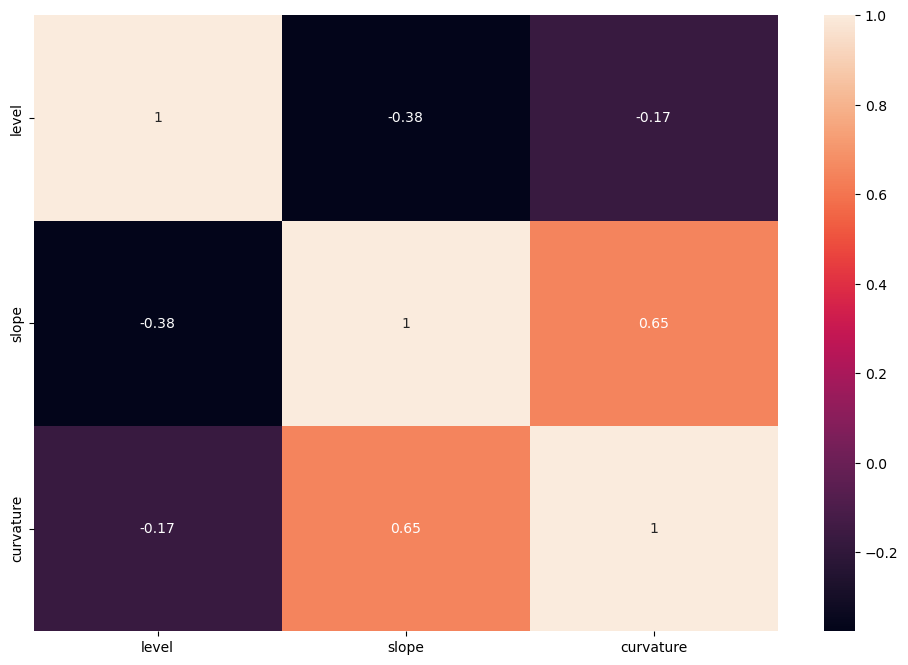

<Axes: >

In [72]:
factor_stats = pd.DataFrame(index=yield_curve_factors.columns, columns=['Mean', 'Std Dev'])
factor_stats['Mean'] = yield_curve_factors.mean()
factor_stats['Std Dev'] = yield_curve_factors.std()

display(factor_stats)
calc_correlations(yield_curve_factors)

### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [73]:
pca = PCA(svd_solver='full')
pca.fit(yield_curve_ts)

pca_loadings = pd.DataFrame(
    pca.components_,
    index=yield_curve_ts.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)
display(pca_loadings.iloc[:,0:2])

,PC1,PC2
1,0.4115,0.4111
2,0.5910,0.3993
5,0.4555,0.0073
7,0.3578,-0.3857
10,-0.0200,-0.0148
20,0.3403,-0.5711
30,0.1724,-0.4432


,Explained Variance Ratio,Cumulative Variance Ratio
PC1,0.9707,0.9707
PC2,0.0253,0.9960
PC3,0.0029,0.9989
PC4,0.0005,0.9994
PC5,0.0004,0.9998
PC6,0.0002,0.9999
PC7,0.0001,1.0000


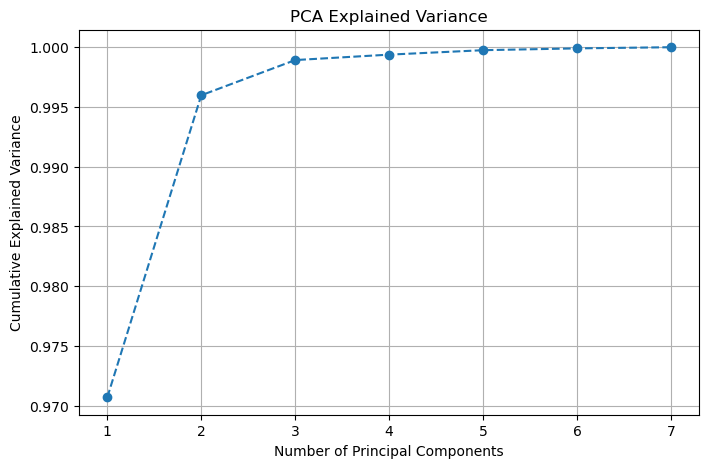

In [63]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

pc_var_ratio = pd.DataFrame({
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Variance Ratio': cumulative_variance
}, index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))])

display(pc_var_ratio)

# Cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


In [64]:
pca_factors_ts = yield_curve_ts@pca_loadings
display(pca_factors_ts.iloc[0:5,0:2])

,PC1,PC2
date,,
1961-06-14,8.0726,-2.8041
1961-06-15,8.1210,-2.8259
1961-06-16,8.1278,-2.8317
1961-06-19,8.1564,-2.8464
1961-06-20,8.1373,-2.8528


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

In [65]:
corr_level_pc1 = yield_curve_factors['level'].corr(pca_factors_ts['PC1'])
corr_slope_pc2 = yield_curve_factors['slope'].corr(pca_factors_ts['PC2'])

print(f"Correlation between Level and PC1: {corr_level_pc1:.2%}")
print(f"Correlation between Slope and PC2: {corr_slope_pc2:.2%}")

Correlation between Level and PC1: 99.85%
Correlation between Slope and PC2: -33.18%
